(dimensionality)=
# Distribution Dimensionality
PyMC provides a number of ways to specify the dimensionality of its distributions. This document provides an overview, and offers some user tips.

## Glossary
In this document we'll be using the term dimensionality to refer to the idea of dimensions. Each of the terms below has a specific
semantic and computational definition in PyMC.  While we share them here they will make much more sense when viewed in the examples below.

+ *Support dimensions* → The core dimensionality of a distribution
+ *Batch dimensions* → Extra dimensions beyond the support dimensionality of a distribution
+ *Implicit dimensions* → Dimensions that follow from the values or shapes of the distribution parameters
+ *Explicit dimensions* → Dimensions that are explicitly defined by one of the following arguments:
    + *Shape* → Number of draws from a distribution
    + *Dims* → An array of dimension names
+ *Coords* → A dictionary mapping dimension names to coordinate values

In [1]:
import pymc as pm
import numpy as np
import aesara.tensor as at

## Univariate distribution example
We can start with the simplest case, a single Normal distribution. We use `.dist` to specify one outside of a PyMC Model.

In [2]:
normal_dist = pm.Normal.dist()

We can then use the {func}`~pymc.draw` function to take a random draw from that distribution.

In [3]:
normal_draw = pm.draw(normal_dist)
normal_draw, normal_draw.ndim

(array(-2.62065421), 0)

In this case we end up with a single scalar value. This means that a Normal distribution has a scalar support dimensionality, as the smallest random draw you can take is a scalar which has a dimension of zero. The support dimensionality of every distribution is hard-coded as a property.

In [4]:
normal_dist.owner.op.ndim_supp

0

### Explicit batch dimensions

If one needs more than a single draw, a natural tendency would be to create multiple copies of the same variable and stack them together.

In [5]:
normal_dists = pm.math.stack([pm.Normal.dist() for _ in range(3)])
pm.draw(normal_dists)

array([-0.06684535,  1.29471918, -0.12572735])

More simply, one can create a *batch* of independent draws from the same distribution family by using the shape argument.

In [6]:
normal_dists = pm.Normal.dist(shape=(3,))
pm.draw(normal_dists)

array([ 1.10453926,  0.93416091, -0.27578331])

In [7]:
normal_dists = pm.Normal.dist(shape=(4, 3))
pm.draw(normal_dists)

array([[ 1.17265064,  0.42953598, -0.28644594],
       [ 1.1532523 , -1.42009449,  1.75785042],
       [ 1.27788459,  0.24717247, -0.05186768],
       [ 0.63788917,  1.40202128, -0.02625937]])

Not only is this more succint, but it produces much more efficient vectorized code. We rarely use the stack approach in PyMC, unless we need to combine draws from distinct distribution families.

### Implicit batch dimensions

It is also possible to create a batch of draws by passing parameters with higher dimensions, without having to specify shape.

In [8]:
normal_dists = pm.Normal.dist(mu=np.array([0, 0, 0]), sigma=np.array([1, 1, 1]))
pm.draw(normal_dists)

array([ 0.20526339, -1.31902695,  0.46685689])

This is equivalent to the previous example with explicit shape, and we could have passed it explicitly here. Because we did not, we refer to these batch dimensions as being *implicit*.

Where this becomes very useful is when we want the parameters to vary across batch dimensions.

In [9]:
pm.draw(pm.Normal.dist(mu=[1, 10, 100], sigma=0.0001))

array([  0.99993126,   9.99984543, 100.00003259])

When the parameters don't have the same shapes, they are broacasted, in a similar way to how NumPy works. In this case `sigma` was broadcasted to match the shape of `mu`.

In [10]:
np.broadcast_arrays([1, 10, 100], 0.0001)

[array([  1,  10, 100]), array([0.0001, 0.0001, 0.0001])]

It's important to understand how NumPy {ref}`broadcasting <numpy:_basics.broadcasting>` works. When you do something that is not valid, you will easily encounter this sort of errors:

In [11]:
try:
    # shapes of (3,) and (2,) can't be broadcasted together
    pm.draw(pm.Normal.dist(mu=[1, 10, 100], sigma=[0.1, 0.1]))
except ValueError as error:
    print(error)

shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F284D96BE60>), TensorConstant{[]}, TensorConstant{11}, TensorConstant{[  1  10 100]}, TensorConstant{(2,) of 0.1})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ()), TensorType(int64, (3,)), TensorType(float64, (2,))]
Inputs shapes: ['No shapes', (0,), (), (3,), (2,)]
Inputs strides: ['No strides', (8,), (), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x7F284D96BE60, array([], dtype=int64), array(11), array([  1,  10, 100]), array([0.1, 0.1])]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that 

### Combining implicit and explicit batch dimensions

You can combine explicit shape dimensions with implicit batch dimensions. As mentioned above, they can provide the same information.

In [12]:
normal_dists = pm.Normal.dist(mu=np.array([0, 1, 2]), sigma=1, shape=(3,))
pm.draw(normal_dists)

array([0.01360448, 0.11874881, 2.71238628])

But shape can also be used to extend beyond any implicit batch dimensions.

In [13]:
normal_dists = pm.Normal.dist(mu=np.array([0, 1, 2]), sigma=1, shape=(4, 3))
pm.draw(normal_dists)

array([[-0.22475842,  1.1818126 ,  1.59941035],
       [-1.18278597,  1.75896918,  1.87504772],
       [-1.48208843,  0.00341356,  0.66390724],
       [-1.55003988,  2.83424746,  2.49958085]])

Note that, due to broadcasting rules, explicit batch dimensions must always "go on the left" of any implicit dimensions. So in the previous example `shape=(4, 3)` is valid, but `shape=(3, 4)` is not, because the `mu` parameter can be broadcasted to the first shape but not to the second.

In [14]:
try:
    pm.draw(pm.Normal.dist(mu=np.array([0, 1, 2]), sigma=1, shape=(3, 4)))
except ValueError as error:
    print(error)

shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3, 4) and arg 1 with shape (3,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F284D6B83C0>), TensorConstant{[3 4]}, TensorConstant{11}, TensorConstant{[0 1 2]}, TensorConstant{1.0})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (2,)), TensorType(int64, ()), TensorType(int64, (3,)), TensorType(float64, ())]
Inputs shapes: ['No shapes', (2,), (), (3,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0x7F284D6B83C0, array([3, 4]), array(11), array([0, 1, 2]), array(1.)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations ca

If you needed the Normal variables to have `shape=(4, 3)`, you can transpose it after defining it.

In [15]:
transposed_normals = pm.Normal.dist(mu=np.array([0, 1, 2]), sigma=1, shape=(4, 3)).T
pm.draw(transposed_normals)

array([[-1.17503239, -1.35392578,  0.9645284 ,  1.36791229],
       [ 0.7740332 ,  1.89822562,  1.94041417,  2.0301242 ],
       [ 1.98223723,  3.10563644,  3.03044539, -0.71757045]])

:::{tip} It's important not to confuse dimensions set in the definition of a distribution versus those set in downstream manipulations like transposition, indexing or broadcasting. When sampling with PyMC (be it via forward sampling or MCMC), the random draws will always emanate from the distribution shape. Notice how in the following example, a different number of "random" draws were actually taken, despite the two variables having the same final shape. :::

In [16]:
vector_normals = pm.Normal.dist(size=(3,))
broadcasted_normal = at.broadcast_to(pm.Normal.dist(), (3,))

In [17]:
pm.draw(vector_normals), pm.draw(broadcasted_normal)

(array([-1.79527244,  0.59187417, -0.12458178]),
 array([-0.34580396, -0.34580396, -0.34580396]))

## Multivariate distribution example

Some distributions by definition return more than one value when evaluated. This may be a vector of values or a matrix or an arbitrary multidimensional tensor. An example is the Multivariate Normal, which always returns a vector (an array with one dimension).

In [18]:
mvnormal_dist = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3))
mvnormal_draw = pm.draw(mvnormal_dist)
mvnormal_draw, mvnormal_draw.ndim

(array([ 0.23006493, -0.51221089,  1.15872558]), 1)

As with any distribution, the support dimensionality is specified as a fixed property

In [19]:
mvnormal_dist.owner.op.ndim_supp

1

Even if you specify a MvNormal with a single dimension, you get back a vector!

In [20]:
smallest_mvnormal_dist = pm.MvNormal.dist(mu=[1], cov=[[1]])
smallest_mvnormal_draw = pm.draw(smallest_mvnormal_dist)
smallest_mvnormal_draw, smallest_mvnormal_draw.ndim

(array([1.56344461]), 1)

### Implicit support dimensions

In the MvNormal examples we just saw, the support dimension was actually implicit. Nowhere did we specify we wanted a vector of 3 or 1 draws. This was inferred from the shape of `mu` and `cov`. As such, we refer to it as being an *implicit support dimension*. We could be a bit more explicit by using shape.

In [21]:
explicit_mvnormal = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3), shape=(3,))
explicit_mvnormal.shape.eval()

array([3])

:::{warning} However, note that at the time of writing shape is simply ignored for support dimensions. It serves merely as a "type-hint" for labeling the expected dimensions. :::

In [22]:
ignored_shape_mvnormal = pm.MvNormal.dist(mu=np.ones(3), cov=np.eye(3), shape=(4,))
explicit_mvnormal.shape.eval()

array([3])

### Explicit batch dimensions

As with univariate distributions, we can add explicit batched dimensions. We will use another vector distribution to illustrate this: the Multinomial. The following snippet defines a matrix of five independent Multinomial distributions, each of which is a vector of size 3.

In [23]:
pm.draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(5, 3)))

array([[0, 2, 3],
       [1, 2, 2],
       [0, 0, 5],
       [0, 2, 3],
       [0, 2, 3]])

:::{warning} Again, note that shape has no effect on the support dimensionality :::

In [24]:
pm.draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(5, 4)))

array([[0, 1, 4],
       [3, 1, 1],
       [1, 0, 4],
       [0, 2, 3],
       [1, 0, 4]])

For the same reason, you must always define explicit batched dimensions "to the left" of the support dimension. The following will not behave as expected.

In [25]:
pm.draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(3, 5)))

array([[0, 3, 2],
       [0, 3, 2],
       [0, 0, 5]])

If you needed the Multinomial variables to have `shape=(3, 5)` you can transpose it after defining it.

In [26]:
transposed_multinomials = pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(5, 3)).T
pm.draw(transposed_multinomials)

array([[1, 0, 0, 0, 0],
       [3, 2, 1, 2, 2],
       [1, 3, 4, 3, 3]])

### Implicit batch dimensions

As with univariate distributions, we can use different parameters for each batched dimension

In [27]:
multinomial_dist = pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6])
pm.draw(multinomial_dist)

array([[0, 1, 4],
       [0, 5, 5]])

Which is equivalent to the more verbose

In [28]:
pm.draw(pm.Multinomial.dist(n=[5, 10], p=[[0.1, 0.3, 0.6], [0.1, 0.3, 0.6]]))

array([[1, 1, 3],
       [1, 0, 9]])

If you are familiar with NumPy broadcasting rules you may be curious of how does PyMC make this work. Naive broadcasting wouldn't work here

In [29]:
try:
    np.broadcast_arrays([5, 10], [0.1, 0.3, 0.6])
except ValueError as exc:
    print(exc)

shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).


To understand what is going on, we need to introduce the concept of parameter core dimensions. The core dimensions of a distribution's parameter are the minimum number of dimensions the parameters need to have in order to define a distribution. In the Multinomial distribution, `n` must at least be an scalar integer, but `p` must be at least a vector that represents the probability of having an outcome on each category. So, for the Multinomial distribution, `n` has 0 core dimensions, and `p` has 1 core dimension. 

So if we have a vector of two `n`, we should actually broadcast the vector of `p` into a matrix with two such vectors, and pair each `n` with each broadcasted row of `p`. This works exactly like `np.vectorize`.

In [30]:
def core_multinomial(n, p):
    print(">>", n, p)
    return pm.draw(pm.Multinomial.dist(n, p))


vectorized_multinomial = np.vectorize(core_multinomial, signature="(),(p)->(p)")
vectorized_multinomial([5, 10], [0.1, 0.3, 0.6])

>> 5 [0.1 0.3 0.6]
>> 10 [0.1 0.3 0.6]


array([[1, 1, 3],
       [3, 3, 4]])

The core dimensionality of each distribution parameter is also hard-coded as a property of each distribution

In [31]:
multinomial_dist.owner.op.ndims_params

(0, 1)

Implicit batch dimensions must still respect broadcasting rules. The following example is not valid because `n` has batched dimensions of `shape=(2,)` and `p` has batched dimensions of `shape=(3,)` which cannot be broadcasted together.

In [32]:
try:
    pm.draw(pm.Multinomial.dist(n=[5, 10], p=[[0.1, 0.3, 0.6], [0.1, 0.3, 0.6], [0.1, 0.3, 0.6]]))
except ValueError as error:
    print(error)

operands could not be broadcast together with remapped shapes [original->remapped]: (2,)  and requested shape (3,)
Apply node that caused the error: multinomial_rv{1, (0, 1), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F28450E1540>), TensorConstant{[]}, TensorConstant{4}, TensorConstant{[ 5 10]}, TensorConstant{[[0.1 0.3 .. 0.3 0.6]]})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ()), TensorType(int64, (2,)), TensorType(float64, (3, 3))]
Inputs shapes: ['No shapes', (0,), (), (2,), (3, 3)]
Inputs strides: ['No strides', (8,), (), (8,), (24, 8)]
Inputs values: [Generator(PCG64) at 0x7F28450E1540, array([], dtype=int64), array(4), array([ 5, 10]), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Ae

### Combining implicit and explicit batch dimensions

You can and should combine implicit dimensions from multidimensional parameters with explicit shape information, which is easier to reason about.

In [33]:
pm.draw(pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6], shape=(2, 3)))

array([[0, 2, 3],
       [1, 2, 7]])

Explicit batch dimensions can still extend beyond any implicit batch dimensions. Again, due to how broadcasting works, explicit batch dimensions must always "go on the left". The following case is invalid, because `n` has batched dimensions of `shape=(2,)`, which cannot be broadcasted to the explicit batch dimensions of `shape=(2, 4)`.

In [34]:
try:
    pm.draw(pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6], shape=(2, 4, 3)))
except ValueError as error:
    print(error)

shape mismatch: objects cannot be broadcast to a single shape
Apply node that caused the error: multinomial_rv{1, (0, 1), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F284503D7E0>), TensorConstant{[2 4]}, TensorConstant{4}, TensorConstant{[ 5 10]}, TensorConstant{[0.1 0.3 0.6]})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (2,)), TensorType(int64, ()), TensorType(int64, (2,)), TensorType(float64, (3,))]
Inputs shapes: ['No shapes', (2,), (), (2,), (3,)]
Inputs strides: ['No strides', (8,), (), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x7F284503D7E0, array([2, 4]), array(4), array([ 5, 10]), array([0.1, 0.3, 0.6])]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: 

## Inspecting dimensionality with a model graph

More often than not distributions are used inside a PyMC model, and as such there are tools that facilitate reasoning about distributions shapes in that context.

In [35]:
with pm.Model() as pmodel:
    mu = pm.Normal("x", mu=0, size=(3))
    sigma = pm.HalfNormal("sigma")
    y = pm.Normal("y", mu=mu, sigma=sigma)

for rv, shape in pmodel.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")

          x: shape=(3,)
sigma_log__: shape=()
      sigma: shape=()
          y: shape=(3,)


An even more powerful tool to understand and debug dimensionality in PyMC is the {func}`~pymc.model_to_graphviz` function. Rather than inspecting array outputs we can instead read the Graphviz output to understand the dimensionality of the variables.

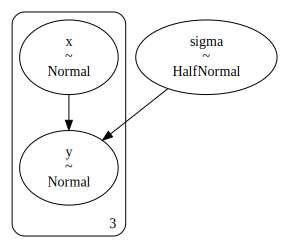

In [36]:
pm.model_to_graphviz(pmodel)

In the example above the number on the bottom left of each box (or plate) indicates the dimensionality of the distributions within. If a distribution is outside of any box with a number, it has a scalar shape.

Let's use this tool to review implicit and explicit dimensions:

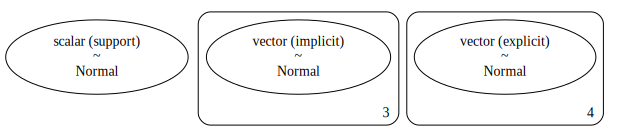

In [37]:
with pm.Model() as pmodel:
    pm.Normal("scalar (support)")
    pm.Normal("vector (implicit)", mu=[1, 2, 3])
    pm.Normal("vector (explicit)", shape=(4,))

pm.model_to_graphviz(pmodel)

## Dims

PyMC supports the concept of `dims`. With many random variables it can become confusing which dimensionality corresponds to which "real world" idea, e.g. number of observations, number of treated units etc. The `dims` argument is an additional human-readable label that can convey this meaning.

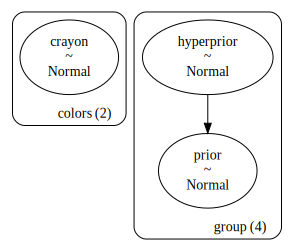

In [38]:
with pm.Model() as pmodel:
    pm.Normal("crayon", size=2, dims="colors")

    hyperprior = pm.Normal("hyperprior", [1, 2, 3, 4], dims="group")
    pm.Normal("prior", mu=hyperprior, dims="group")


pm.model_to_graphviz(pmodel)

Where `dims` can become increasingly powerful is with the use of `coords` specified in the model itself. This gives a unique label to each `dim` entry, rendering it much more meaningful.

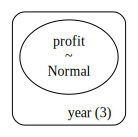

In [39]:
with pm.Model(
    coords={
        "year": [2020, 2021, 2022],
    }
) as pmodel:

    pm.Normal("profit", dims="year")

pm.model_to_graphviz(pmodel)

Note that the dimensionality of the distribution was actually defined by the `dims` used. We did not pass shape or define implicit batched dimensions.

Let us to review the different dimensionality flavours with a Multivariate Normal example.

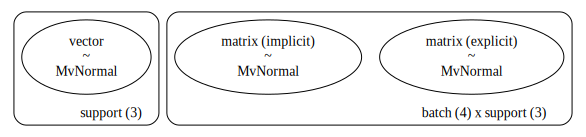

In [40]:
with pm.Model(
    coords={
        "batch": [0, 1, 2, 3],
    }
) as pmodel:
    pm.MvNormal("vector", mu=[0, 0, 0], cov=np.eye(3), dims=("support",))
    pm.MvNormal("matrix (implicit)", mu=np.zeros((4, 3)), cov=np.eye(3), dims=("batch", "support"))
    pm.MvNormal(
        "matrix (explicit)", mu=[0, 0, 0], cov=np.eye(3), shape=(4, 3), dims=("batch", "support")
    )

pm.model_to_graphviz(pmodel)

:::{tip} For final model publication we suggest dims and coords as the labels will be passed to {class}'arviz.InferenceData'. This is both best practice transparency and readability for others. It also is useful in single developer workflows, for example, in cases where there is a 3 dimensional or higher distribution it'll help indiciate which dimension corresponds to which model concept. :::

## User caution and practical tips

While we provide all these tools for convenience, and while PyMC does it best to understand user intent, the result of mixed dimensionality tools may not always result in the final dimensionality intended. Sometimes the model may not indicate an error until sampling, or not indicate an issue at all. When working with dimensionality, particular more complex ones we suggest:

* Using `model_to_graphviz` to visualize your model before sampling
* Using `draw` or `sample_prior predictive` to catch errors early
* Inspecting the returned `az.InferenceData` object to ensure all array sizes are as intended
* Defining shapes with prime numbers when tracking down errors.